## PF Setup

In [1]:
# import all libraries and start powerfactory
import sys
sys.path.append(r"C:\Program Files\DIgSILENT\PowerFactory 2024 SP4\Python\3.10")
import powerfactory as pf
import numpy as np
import re
import itertools 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
from matplotlib.transforms import Affine2D
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
# IMPORTANT: make sure that PowerFactory is not already running 
try:
    app = pf.GetApplicationExt()
except pf.ExitError as error:
    print(f"error code --> {error.code}")

app.Show()

In [2]:
# programmatically open the pfd file.
import_path = r'Nine-bus Grid Cortex Feb2025.pfd'
imp = app.GetFromStudyCase('ComPfdImport')
imp.g_file = import_path
imp.activatePrj = 1
imp.Execute()

0

## RL

In [3]:
import os
import numpy as np
import pandas as pd
import time
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

class Actor(nn.Module):
    def __init__(self, state_size, action_size=1):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_size, action_size=1):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class SimpleDDPGAgent:
    def __init__(
        self,
        state_size=6,
        action_size=1,
        actor_lr=1e-3,
        critic_lr=1e-3,
        gamma=0.99,
        tau=0.005,
        max_memory=10000,
        init_noise_std=0.3,
        min_noise_std=0.05,
        noise_decay=0.995,
        device=None
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.actor = Actor(state_size, action_size).to(self.device)
        self.critic = Critic(state_size, action_size).to(self.device)

        self.target_actor = Actor(state_size, action_size).to(self.device)
        self.target_critic = Critic(state_size, action_size).to(self.device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.tau = tau

        self.noise_std = init_noise_std
        self.min_noise_std = min_noise_std
        self.noise_decay = noise_decay

        self.epsilon = self.noise_std
        self.epsilon_min = self.min_noise_std
        self.epsilon_decay = self.noise_decay

        self.memory = []
        self.max_memory = max_memory

    def select_action(self, state, explore=True):
        self.actor.eval()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_tensor = self.actor(state_tensor)
        self.actor.train()

        action = action_tensor.cpu().numpy()[0]
        a = float(action[0])

        if explore:
            a += np.random.normal(0.0, self.noise_std)

        a = np.clip(a, -1.0, 1.0)
        return a

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, float(action), reward, next_state, done))
        if len(self.memory) > self.max_memory:
            self.memory.pop(0)

    def _soft_update(self, main, target):
        for mp, tp in zip(main.parameters(), target.parameters()):
            tp.data.copy_(self.tau * mp.data + (1.0 - self.tau) * tp.data)

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return None

        batch = random.sample(self.memory, batch_size)

        states = torch.FloatTensor([x[0] for x in batch]).to(self.device)
        actions = torch.FloatTensor([[x[1]] for x in batch]).to(self.device)
        rewards = torch.FloatTensor([x[2] for x in batch]).to(self.device)
        next_states = torch.FloatTensor([x[3] for x in batch]).to(self.device)
        dones = torch.FloatTensor([x[4] for x in batch]).to(self.device)

        current_Q = self.critic(states, actions).squeeze(1)

        with torch.no_grad():
            next_actions = self.target_actor(next_states)
            target_Q_next = self.target_critic(next_states, next_actions).squeeze(1)
            target_Q = rewards + self.gamma * target_Q_next * (1 - dones)

        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        pred_actions = self.actor(states)
        actor_loss = -self.critic(states, pred_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self._soft_update(self.actor, self.target_actor)
        self._soft_update(self.critic, self.target_critic)

        return critic_loss.item() + actor_loss.item()

    def update_epsilon(self):
        if self.noise_std > self.min_noise_std:
            self.noise_std *= self.noise_decay
        self.epsilon = self.noise_std

    def save(self, filepath):
        torch.save(
            {
                "actor_state": self.actor.state_dict(),
                "critic_state": self.critic.state_dict(),
                "target_actor_state": self.target_actor.state_dict(),
                "target_critic_state": self.target_critic.state_dict(),
                "actor_optimizer_state": self.actor_optimizer.state_dict(),
                "critic_optimizer_state": self.critic_optimizer.state_dict(),
                "noise_std": self.noise_std,
                "memory": self.memory,
            },
            filepath,
        )
        print(f"DDPG Agent saved to {filepath}")

    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.actor.load_state_dict(checkpoint["actor_state"])
        self.critic.load_state_dict(checkpoint["critic_state"])
        self.target_actor.load_state_dict(checkpoint["target_actor_state"])
        self.target_critic.load_state_dict(checkpoint["target_critic_state"])
        self.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state"])
        self.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state"])
        self.noise_std = checkpoint.get("noise_std", self.noise_std)
        self.memory = checkpoint.get("memory", [])
        self.epsilon = self.noise_std
        print(f"DDPG Agent loaded from {filepath}")

print("SimpleDDPGAgent loaded")


SimpleDDPGAgent loaded


## Environment

In [ ]:
import os
import re
import numpy as np
import pandas as pd

class PowerFactoryEnv:
    def __init__(self, app, path, simtime, max_steps=5, save_all=False):
        self.app = app
        self.path = path
        self.simtime = simtime
        self.max_steps = max_steps
        self.save_all = save_all
        print(f"Initializing Environment (simtime={simtime}s, max_steps={max_steps})")

        # Get elements
        self.G1 = app.GetCalcRelevantObjects('G1.ElmSym')[0]
        self.GFM = app.GetCalcRelevantObjects('GFM.ElmGenstat')[0]
        self.GFL = app.GetCalcRelevantObjects('PV GFL.ElmPvsys')[0]
        self.Loads = app.GetCalcRelevantObjects('*.ElmLod')
        self.Transformers = app.GetCalcRelevantObjects('*.ElmTr2')
        self.DslComponents = app.GetCalcRelevantObjects('*.ElmDsl')
        self.Buses = app.GetCalcRelevantObjects('*.ElmTerm')
        self.Lines = app.GetCalcRelevantObjects('*.ElmLne')


        self.Ctot = 567.5
        self.alpha = 0.5551
        self.beta = 0.2026
        self.gamma = 1.0573

        self.base_load_P = [125.0, 90.0, 100.0]
        self.base_load_Q = [50.0, 30.0, 35.0]
        total_base_P = sum(self.base_load_P)
        self.load_fractions_P = [p / total_base_P for p in self.base_load_P]
        self.load_fractions_Q = [q / sum(self.base_load_Q) for q in self.base_load_Q]
        self.target_loading = 0.90

        self.P_Suppl = self.DslComponents[11]
        self.fixed_params = {
            "Tw": 5.0, "T1": 0.5, "T2": 0.1,
            "T3": 1.0, "T4": 2.0, "Vmin": -0.1, "Vmax": 0.1
        }
        self.K_current = 0.0
        self.K_min = 0.0
        self.K_max = 10.0

        self.coarse_K_values = [3, 7]
        self.use_coarse_search = True
        self.coarse_step_counter = 0

        self.current_eSG = 0.0
        self.current_eGFM = 0.0
        self.current_eGFL = 0.0
        self.baseline_pre_state = None
        self.baseline_post_state = None

        self.STATE_IDX = {
            "eSG": 0, "eGFM": 1, "eGFL": 2,
            "zeta": 3, "sigma": 4, "freq": 5
        }

        print(f"Environment ready (K in [{self.K_min}, {self.K_max}])")

    def set_output_path(self, new_path):
        self.path = new_path
        os.makedirs(new_path, exist_ok=True)

    def _update_controller_params(self):
        new_params = [
            self.K_current,
            self.fixed_params["Tw"], self.fixed_params["T1"],
            self.fixed_params["T2"], self.fixed_params["T3"],
            self.fixed_params["T4"], self.fixed_params["Vmin"],
            self.fixed_params["Vmax"]
        ]
        self.P_Suppl.params = new_params

    def _configure_statics(self, eSG, eGFM, eGFL):
        rSG = float(eSG * self.Ctot)
        rGFM = float(eGFM * self.Ctot)
        rGFL = float(eGFL * self.Ctot)

        if eSG >= eGFM:
            self.G1.ip_ctrl = 1
            self.GFM.ip_ctrl = 0
        else:
            self.G1.ip_ctrl = 0
            self.GFM.ip_ctrl = 1
        self.GFL.ip_ctrl = 0

        pDSG = np.sign(71.6) * self.alpha * rSG
        pDGFM = np.sign(85) * self.alpha * rGFM
        pDGFL = np.sign(163) * self.alpha * rGFL
        qDSG = np.sign(27) * self.beta * rSG
        qDGFM = np.sign(-10.9) * self.beta * rGFM
        qDGFL = np.sign(6.7) * self.beta * rGFL

        self.G1.q_min = -1
        self.G1.q_max = 1
        self.G1.Pmin_uc = 0
        self.G1.Pmax_uc = self.G1.Pnom
        self.G1.P_max = self.G1.Pnom
        self.G1.pmaxratf = 1
        self.G1.typ_id.sgn = rSG
        self.G1.pgini = pDSG
        self.G1.qgini = qDSG

        self.GFM.q_min = -1
        self.GFM.q_max = 1
        self.GFM.Pmin_uc = 0
        self.GFM.Pmax_uc = self.GFM.Pnom
        self.GFM.P_max = self.GFM.Pnom
        self.GFM.pmaxratf = 1
        self.GFM.sgn = rGFM
        self.GFM.pgini = pDGFM
        self.GFM.qgini = qDGFM

        self.GFL.Pmin_uc = 0
        self.GFL.Pmax_uc = self.GFL.Pnom
        self.GFL.P_max = self.GFL.Pnom
        self.GFL.pmaxratf = 1
        self.GFL.sgn = rGFL * 1000
        self.GFL.pgini = pDGFL * 1000
        self.GFL.qgini = qDGFL * 1000

        self.Transformers[2].typ_id.strn = self.gamma * rSG
        self.Transformers[0].typ_id.strn = self.gamma * rGFL
        self.Transformers[1].typ_id.strn = self.gamma * rGFM
        if len(self.Transformers) > 3:
            self.Transformers[3].typ_id.strn = self.gamma * rGFL

        total_gen_P = pDSG + pDGFM + pDGFL
        total_gen_Q = qDSG + qDGFM + qDGFL
        total_load_P = total_gen_P * self.target_loading
        total_load_Q = total_gen_Q * self.target_loading

        for i in range(min(3, len(self.Loads))):
            self.Loads[i].plini = total_load_P * self.load_fractions_P[i]
            self.Loads[i].qlini = total_load_Q * self.load_fractions_Q[i]

    def _configure_modal_analysis(self):
        commod = self.app.GetFromStudyCase("ComMod")
        commod.init = 0
        commod.iopt_met = 0
        commod.iLeft = 1
        commod.iRight = 1
        commod.iPart = 1
        commod.iQRorQZ = 0
        commod.useBalancing = 1
        commod.iSysMatsMatl = 1
        commod.iEValMatl = 1
        commod.iLEVMatl = 0
        commod.iREVMatl = 0
        commod.iPartMatl = 0
        commod.dirMatl = self.path
        commod.outputType = 1
        return commod

    def _cleanup_mtl_files(self):
        for f in ["EVals.mtl", "Amat.mtl", "Jacobian.mtl"]:
            file_path = os.path.join(self.path, f)
            try:
                if os.path.exists(file_path):
                    os.remove(file_path)
            except OSError:
                pass

    def _read_eigenvalues(self):
        evals_path = os.path.join(self.path, "EVals.mtl")
        if not os.path.exists(evals_path):
            return None
        try:
            tmp1 = list(np.loadtxt(evals_path, delimiter=",", dtype="str"))
            eigenvalues = np.empty((len(tmp1), 2))
            for e in range(len(tmp1)):
                tmp2 = re.split("  ", tmp1[e])
                eigenvalues[e, 0] = float(tmp2[2])
                eigenvalues[e, 1] = float(tmp2[3])
            return eigenvalues
        except Exception as e:
            print(f"Error reading eigenvalues: {e}")
            return None

    def _extract_state(self, eigenvalues):
        if eigenvalues is None or len(eigenvalues) == 0:
            return np.array(
                [self.current_eSG, self.current_eGFM, self.current_eGFL, 0.0, 0.0, 0.5],
                dtype=np.float32
            )

        em_modes = []
        for i in range(len(eigenvalues)):
            sigma = eigenvalues[i, 0]
            omega = abs(eigenvalues[i, 1])
            freq = omega / (2 * np.pi)

            if 0.1 <= freq <= 2.0:
                denom = np.sqrt(sigma**2 + omega**2)
                zeta = -sigma / denom if denom > 0 else 0.0
                em_modes.append([sigma, omega, freq, zeta])

        if len(em_modes) == 0:
            return np.array(
                [self.current_eSG, self.current_eGFM, self.current_eGFL, 0.0, 0.0, 0.5],
                dtype=np.float32
            )

        worst = min(em_modes, key=lambda x: x[3])

        sigma_raw = worst[0]
        freq_raw = worst[2]
        zeta_raw = worst[3]

        sigma_norm = np.clip((sigma_raw + 5.0) / 10.0, 0.0, 1.0)
        freq_norm = np.clip((freq_raw - 0.1) / 1.9, 0.0, 1.0)
        zeta_norm = np.clip(zeta_raw, 0.0, 1.0)

        return np.array(
            [self.current_eSG, self.current_eGFM, self.current_eGFL, zeta_norm, sigma_norm, freq_norm],
            dtype=np.float32
        )

    def _delete_all_events(self):
        try:
            events_folder = self.app.GetFromStudyCase("IntEvt")
            if events_folder is None:
                return
            all_events = list(events_folder.GetContents())
            for evt in all_events:
                try:
                    evt.Delete()
                except Exception:
                    pass
        except Exception as e:
            print(f"Event deletion warning: {e}")

    def introduce_event(self):
        try:
            events_folder = self.app.GetFromStudyCase("IntEvt")
            self._delete_all_events()

            evt1 = events_folder.CreateObject("EvtShc", "fault_event")
            evt1.p_target = self.Lines[4]
            evt1.time = 20.0
            evt1.i_shc = 0

            try:
                evt1.tclear = 20.05
            except AttributeError:
                try:
                    evt1.tclear = 20.05
                except AttributeError:
                    print("Could not set fault duration")

            dur = getattr(evt1, "durt", 0.05)
            print(f"Fault event created: t={evt1.time}s, duration={dur}s")

        except Exception as e:
            print(f"Event creation failed: {e}")
            import traceback
            traceback.print_exc()

    def _configure_elmres(self):
        elmres = self.app.GetFromStudyCase("All calculations.ElmRes")

        try:
            old_vars = list(elmres.GetContents())
            for var in old_vars:
                try:
                    var.Delete()
                except Exception:
                    pass
        except Exception:
            pass

        elmres.AddVars(self.G1, "m:P:bus1")
        elmres.AddVars(self.G1, "m:Q:bus1")
        elmres.AddVars(self.G1, "n:fehz:bus1")
        elmres.AddVars(self.GFM, "m:P:bus1")
        elmres.AddVars(self.GFM, "m:Q:bus1")
        elmres.AddVars(self.GFM, "n:fehz:bus1")
        elmres.AddVars(self.GFL, "m:P:bus1")
        elmres.AddVars(self.GFL, "m:Q:bus1")
        elmres.AddVars(self.GFL, "n:fehz:bus1")

        for bus in self.Buses:
            elmres.AddVars(bus, "m:u1")
            elmres.AddVars(bus, "m:phiu1")
            elmres.AddVars(bus, "m:fehz")

        for line in self.Lines:
            elmres.AddVars(line, "m:I:bus1")
            elmres.AddVars(line, "m:I:bus2")

        return elmres

    def _clear_simulation_results(self):
        try:
            elmres = self.app.GetFromStudyCase("All calculations.ElmRes")
            if elmres:
                elmres.Clear()
        except Exception:
            pass

    def reset(self, eSG, eGFM, eGFL, episode_num):
        print("=" * 70)
        print(f"RESET: Episode {episode_num}")
        print("=" * 70)
        print(f"Mix: SG={eSG:.1%}, GFM={eGFM:.1%}, GFL={eGFL:.1%}")

        try:
            self.app.ClearOutputWindow()
            self._clear_simulation_results()
            self._delete_all_events()
        except Exception as e:
            print(f"Clearing warning: {e}")

        self.current_eSG = eSG
        self.current_eGFM = eGFM
        self.current_eGFL = eGFL
        self.coarse_step_counter = 0

        self._configure_statics(eSG, eGFM, eGFL)

        cominc = self.app.GetFromStudyCase("ComInc")
        cominc.iopt_sim = "rms"
        cominc.iopt_net = "sym"
        cominc.iopt_show = 1
        cominc.dtgrd = 0.001
        cominc.Execute()

        self.K_current = 0.0
        self._update_controller_params()
        print("System initialized (K=0)")

        print("Phase A: Pre-fault modal analysis...")
        commod = self._configure_modal_analysis()
        commod.initMode = 1
        commod.Execute()

        eigenvalues_pre = self._read_eigenvalues()

        if eigenvalues_pre is not None:
            eigenvalues_df = pd.DataFrame(eigenvalues_pre, columns=["sigma", "omega"])
            eigenvalues_df["freq_Hz"] = eigenvalues_df["omega"] / (2 * np.pi)
            eigenvalues_df["zeta"] = -eigenvalues_df["sigma"] / np.sqrt(
                eigenvalues_df["sigma"]**2 + eigenvalues_df["omega"]**2
            )
            eigenvalues_df.to_csv(os.path.join(self.path, "eigenvalues_PRE_FAULT.csv"), index=False)
            print("Saved: eigenvalues_PRE_FAULT.csv")

        self._cleanup_mtl_files()
        baseline_pre_state = self._extract_state(eigenvalues_pre)

        zeta_idx = self.STATE_IDX["zeta"]
        sigma_idx = self.STATE_IDX["sigma"]
        print(f"Pre-fault: zeta={baseline_pre_state[zeta_idx]:.4f}, sigma_norm={baseline_pre_state[sigma_idx]:.4f}")

        print("Re-initializing for clean simulation...")
        cominc.Execute()
        self._update_controller_params()

        print("Configuring result variables...")
        elmres = self._configure_elmres()

        self.introduce_event()

        print(f"Running simulation (0-{self.simtime}s with fault at t=20s)...")
        comsim = self.app.GetFromStudyCase("ComSim")
        comsim.tstop = self.simtime
        result_code = comsim.Execute()

        if result_code != 0:
            print(f"Simulation failed: code {result_code}")
        else:
            print("Simulation completed")

        try:
            elmres.Load()

            comres = self.app.GetFromStudyCase("ComRes")
            comres.pResult = elmres
            comres.calTp = 0
            comres.iopt_exp = 6
            comres.f_name = os.path.join(self.path, "timeseries_FULL_SIMULATION.csv")
            comres.iopt_locn = 1
            comres.numberPrecisionFixed = 9
            comres.Execute()

            if os.path.exists(os.path.join(self.path, "timeseries_FULL_SIMULATION.csv")):
                print("Saved: timeseries_FULL_SIMULATION.csv")
            else:
                print("Time-series file not found after save")

            elmres.Clear()

        except Exception as e:
            print(f"Could not save time-series: {e}")

        print("Phase C: Post-fault modal analysis...")
        commod.initMode = 0
        commod.Execute()

        eigenvalues_post = self._read_eigenvalues()

        if eigenvalues_post is not None:
            eigenvalues_df = pd.DataFrame(eigenvalues_post, columns=["sigma", "omega"])
            eigenvalues_df["freq_Hz"] = eigenvalues_df["omega"] / (2 * np.pi)
            eigenvalues_df["zeta"] = -eigenvalues_df["sigma"] / np.sqrt(
                eigenvalues_df["sigma"]**2 + eigenvalues_df["omega"]**2
            )
            eigenvalues_df.to_csv(os.path.join(self.path, "eigenvalues_POST_FAULT.csv"), index=False)
            print("Saved: eigenvalues_POST_FAULT.csv")

        self._cleanup_mtl_files()
        baseline_post_state = self._extract_state(eigenvalues_post)
        print(f"Post-fault: zeta={baseline_post_state[zeta_idx]:.4f}, sigma_norm={baseline_post_state[sigma_idx]:.4f}")

        sigma_raw = (baseline_post_state[sigma_idx] * 10.0) - 5.0

        baseline_summary = {
            "episode": episode_num,
            "K": 0.0,
            "eSG": self.current_eSG,
            "eGFM": self.current_eGFM,
            "eGFL": self.current_eGFL,
            "pre_fault_zeta": float(baseline_pre_state[zeta_idx]),
            "pre_fault_sigma": float((baseline_pre_state[sigma_idx] * 10.0) - 5.0),
            "post_fault_zeta": float(baseline_post_state[zeta_idx]),
            "post_fault_sigma": float(sigma_raw),
        }

        pd.DataFrame([baseline_summary]).to_csv(os.path.join(self.path, "baseline_summary.csv"), index=False)
        print("Saved: baseline_summary.csv")

        self.baseline_pre_state = baseline_pre_state
        self.baseline_post_state = baseline_post_state

        print("Baseline established")
        print("=" * 70)

        return baseline_post_state.copy()

    def step(self, action, episode_num, step_num, use_coarse=None):
        print("-" * 70)
        print(f"STEP {step_num}")
        print("-" * 70)

        if step_num > 1:
            try:
                self._clear_simulation_results()
                self._delete_all_events()
            except Exception:
                pass

        if use_coarse is None:
            use_coarse = self.use_coarse_search

        if use_coarse and self.coarse_step_counter < len(self.coarse_K_values):
            K_new = self.coarse_K_values[self.coarse_step_counter]
            self.coarse_step_counter += 1
            print(f"COARSE SEARCH: K={K_new:.2f} ({self.coarse_step_counter}/{len(self.coarse_K_values)})")
        else:
            a = float(action)
            K_new = self.K_min + (a + 1.0) * 0.5 * (self.K_max - self.K_min)
            K_new = float(np.clip(K_new, self.K_min, self.K_max))
            print(f"AGENT: K={K_new:.2f}")

        self.K_current = K_new
        self._update_controller_params()

        cominc = self.app.GetFromStudyCase("ComInc")
        cominc.Execute()
        self._update_controller_params()

        self.introduce_event()

        print(f"Running simulation (0-{self.simtime}s with fault)...")
        comsim = self.app.GetFromStudyCase("ComSim")
        comsim.tstop = self.simtime
        result_code = comsim.Execute()

        if result_code != 0:
            print(f"Simulation failed: code {result_code}")
            return None

        save_timeseries = (step_num == 1) or (step_num == self.max_steps)

        if save_timeseries:
            try:
                elmres = self.app.GetFromStudyCase("All calculations.ElmRes")
                elmres.Load()

                comres = self.app.GetFromStudyCase("ComRes")
                comres.pResult = elmres
                comres.iopt_exp = 6
                comres.f_name = os.path.join(self.path, f"timeseries_step{step_num:02d}_K{self.K_current:.2f}.csv")
                comres.iopt_locn = 1
                comres.numberPrecisionFixed = 9
                comres.Execute()
                print(f"Saved: timeseries_step{step_num:02d}_K{self.K_current:.2f}.csv")

                elmres.Clear()

            except Exception as e:
                print(f"Could not save time-series: {e}")

        print("Post-fault modal analysis (t=60s)...")
        commod = self._configure_modal_analysis()
        commod.initMode = 0
        commod.Execute()

        eigenvalues_post = self._read_eigenvalues()

        if eigenvalues_post is not None:
            eigenvalues_df = pd.DataFrame(eigenvalues_post, columns=["sigma", "omega"])
            eigenvalues_df["freq_Hz"] = eigenvalues_df["omega"] / (2 * np.pi)
            eigenvalues_df["zeta"] = -eigenvalues_df["sigma"] / np.sqrt(
                eigenvalues_df["sigma"]**2 + eigenvalues_df["omega"]**2
            )
            eigenvalues_df.to_csv(
                os.path.join(self.path, f"eigenvalues_step{step_num:02d}_K{self.K_current:.2f}.csv"),
                index=False
            )
            print(f"Saved: eigenvalues_step{step_num:02d}_K{self.K_current:.2f}.csv")

        self._cleanup_mtl_files()

        controlled_post_state = self._extract_state(eigenvalues_post)

        if (not isinstance(controlled_post_state, np.ndarray)) or (len(controlled_post_state) != 6):
            print(f"Invalid state returned: {controlled_post_state}")
            return None

        zeta_idx = self.STATE_IDX["zeta"]
        sigma_idx = self.STATE_IDX["sigma"]
        freq_idx = self.STATE_IDX["freq"]

        sigma_raw = (controlled_post_state[sigma_idx] * 10.0) - 5.0
        freq_raw = (controlled_post_state[freq_idx] * 1.9) + 0.1
        baseline_sigma_raw = (self.baseline_post_state[sigma_idx] * 10.0) - 5.0

        step_summary = {
            "step": step_num,
            "K": self.K_current,
            "eSG": self.current_eSG,
            "eGFM": self.current_eGFM,
            "eGFL": self.current_eGFL,
            "post_fault_zeta": float(controlled_post_state[zeta_idx]),
            "post_fault_sigma": float(sigma_raw),
            "post_fault_freq": float(freq_raw),
            "baseline_post_zeta": float(self.baseline_post_state[zeta_idx]),
            "baseline_post_sigma": float(baseline_sigma_raw),
        }

        summary_path = os.path.join(os.path.dirname(self.path), "step_summary.csv")
        summary_df = pd.DataFrame([step_summary])

        if os.path.exists(summary_path):
            summary_df.to_csv(summary_path, mode="a", header=False, index=False)
        else:
            summary_df.to_csv(summary_path, index=False)

        print(f"Result: zeta={controlled_post_state[zeta_idx]:.4f}, sigma={sigma_raw:.4f}")
        print(f"vs Baseline: zeta={self.baseline_post_state[zeta_idx]:.4f}, sigma={baseline_sigma_raw:.4f}")
        print("-" * 70)

        return controlled_post_state

print("Environment class loaded")


## main

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import time
import random
from datetime import datetime

CONFIG = {
    "save_path": r"E:\Users\saigalm\Unified_Training_FINAL_12",
    "simtime": 60,
    "max_steps_per_mix": 10,
    "batch_size": 32,
    "min_replay_size": 100,
    "target_zeta": 0.05,
    "reward_per_zeta": 100.0,
    "target_bonus": 300.0,
    "sigma_pos_penalty": -1000.0,
    "sigma_negative_bonus": 200.0,
    "mix_step_pct": 1,
    "save_every": 50,
    "use_coarse_search": True,
}

os.makedirs(CONFIG["save_path"], exist_ok=True)

def generate_mixes(step_pct=1):
    mixes = []
    for sg in range(1, 100, step_pct):
        for gfm in range(1, 100 - sg, step_pct):
            gfl = 100 - sg - gfm
            if gfl < 1:
                continue
            mixes.append((sg / 100.0, gfm / 100.0, gfl / 100.0))
    return mixes

def create_mix_folder(base_path, eSG, eGFM, eGFL):
    mix_id = f"{int(eSG*100):02d}_{int(eGFM*100):02d}_{int(eGFL*100):02d}"
    mix_folder = os.path.join(base_path, f"mix_{mix_id}")
    baseline_folder = os.path.join(mix_folder, "baseline")
    os.makedirs(baseline_folder, exist_ok=True)
    return mix_folder, baseline_folder, mix_id

def save_mix_info(mix_folder, info_dict):
    info_path = os.path.join(mix_folder, "mix_info.json")
    try:
        with open(info_path, "w") as f:
            json.dump(info_dict, f, indent=2)
        return True
    except Exception as e:
        print(f"Failed to save mix_info.json: {e}")
        return False

def denormalize_sigma(sigma_norm):
    return (sigma_norm * 10.0) - 5.0

def compute_reward(baseline_post, controlled_post, config):
    baseline_sigma = denormalize_sigma(baseline_post[4])
    controlled_sigma = denormalize_sigma(controlled_post[4])

    baseline_zeta = baseline_post[3]
    controlled_zeta = controlled_post[3]

    sigma_improvement = baseline_sigma - controlled_sigma
    zeta_improvement = controlled_zeta - baseline_zeta

    reward = 100.0 * sigma_improvement + 50.0 * zeta_improvement

    if controlled_sigma >= 0:
        penalty = 1000.0 * (1.0 + controlled_sigma)
        penalty = np.clip(penalty, 0.0, 15000.0)
        reward -= penalty
        status = f"UNSTABLE sigma={controlled_sigma:.4f}"
    else:
        reward += 200.0
        if controlled_zeta >= config["target_zeta"]:
            reward += 300.0
            status = f"STABILIZED zeta={controlled_zeta:.4f}, sigma={controlled_sigma:.4f}"
        else:
            status = f"STABLE_LOW_DAMP zeta={controlled_zeta:.4f}, sigma={controlled_sigma:.4f}"

    return reward, status

print("Helper functions loaded")

print("=" * 70)
print("INITIALIZING ENVIRONMENT & AGENT")
print("=" * 70)

rl_env = PowerFactoryEnv(
    app=app,
    path=CONFIG["save_path"],
    simtime=CONFIG["simtime"],
    max_steps=CONFIG["max_steps_per_mix"],
    save_all=False
)

print("PowerFactory Environment initialized")

rl_agent = SimpleDDPGAgent(
    state_size=6,
    action_size=1,
    actor_lr=1e-3,
    critic_lr=1e-3,
    gamma=0.99,
    tau=0.005,
    max_memory=10000,
    init_noise_std=0.3,
    min_noise_std=0.05,
    noise_decay=0.995
)

print("DDPG Agent initialized")
print("State size: 6")
print("Action size: 1")
print(f"Memory capacity: {rl_agent.max_memory}")
print(f"Initial epsilon: {rl_agent.epsilon:.3f}")
print()

print("=" * 70)
print("UNIFIED PIPELINE: SWEEP + RL TRAINING")
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

all_mixes = generate_mixes(step_pct=CONFIG["mix_step_pct"])
print(f"Total mixes to process: {len(all_mixes)}")

print("Shuffling mix order for diverse training...")
random.seed(42)
shuffled_indices = list(range(len(all_mixes)))
random.shuffle(shuffled_indices)
print("Mixes shuffled (seed=42)")

shuffle_order_path = os.path.join(CONFIG["save_path"], "shuffle_order.json")
with open(shuffle_order_path, "w") as f:
    json.dump({"shuffled_indices": shuffled_indices, "seed": 42}, f)
print("Shuffle order saved to shuffle_order.json")
print()

results_summary = []
stable_mixes = []
low_damp_mixes = []
sigma_pos_mixes = []
failed_mixes = []
training_log = []

checkpoint_path = os.path.join(CONFIG["save_path"], "checkpoint.json")
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, "r") as f:
        checkpoint = json.load(f)
    start_idx = checkpoint["last_completed_idx"] + 1

    try:
        with open(shuffle_order_path, "r") as f:
            saved_shuffle = json.load(f)
        if saved_shuffle["shuffled_indices"] != shuffled_indices:
            print("WARNING: Shuffle order mismatch. Using saved order.")
            shuffled_indices = saved_shuffle["shuffled_indices"]
    except Exception:
        print("Could not verify shuffle order")

    try:
        results_summary = pd.read_csv(os.path.join(CONFIG["save_path"], "summary_all_mixes.csv")).to_dict("records")
        stable_mixes = pd.read_csv(os.path.join(CONFIG["save_path"], "stable_mixes.csv")).to_dict("records")
        low_damp_mixes = pd.read_csv(os.path.join(CONFIG["save_path"], "low_damp_mixes.csv")).to_dict("records")
        sigma_pos_mixes = pd.read_csv(os.path.join(CONFIG["save_path"], "sigma_pos_mixes.csv")).to_dict("records")
        failed_mixes = pd.read_csv(os.path.join(CONFIG["save_path"], "failed_mixes.csv")).to_dict("records")
        training_log = pd.read_csv(os.path.join(CONFIG["save_path"], "training_log.csv")).to_dict("records")
        print(f"Loaded existing logs ({len(results_summary)} mixes)")
    except Exception as e:
        print(f"No existing logs found: {e}")

    agent_path = os.path.join(CONFIG["save_path"], "agent.pth")
    if os.path.exists(agent_path):
        try:
            rl_agent.load(agent_path)
            print("Loaded agent weights from checkpoint")
        except Exception as e:
            print(f"Could not load agent weights: {e}")

    print(f"Resuming from mix {start_idx}/{len(all_mixes)}")
else:
    start_idx = 0
    print("Starting fresh from mix 0")

print()

start_time = time.time()
MAX_RETRIES = 3

for processed_count in range(start_idx, len(all_mixes)):
    original_idx = shuffled_indices[processed_count]
    eSG, eGFM, eGFL = all_mixes[original_idx]

    mix_folder, baseline_folder, mix_id = create_mix_folder(
        CONFIG["save_path"], eSG, eGFM, eGFL
    )
    rl_env.set_output_path(baseline_folder)

    print(f"\n{'='*70}")
    print(f"[{processed_count+1}/{len(all_mixes)}] Processing mix_{mix_id}")
    print(f"Original index: {original_idx} (shuffled)")
    print(f"SG={eSG:.1%}, GFM={eGFM:.1%}, GFL={eGFL:.1%}")
    print(f"{'='*70}")

    baseline_post = None
    for attempt in range(MAX_RETRIES):
        try:
            baseline_post = rl_env.reset(eSG, eGFM, eGFL, episode_num=processed_count + 1)

            if baseline_post is None:
                raise ValueError("reset() returned None")
            if (not isinstance(baseline_post, np.ndarray)) or (len(baseline_post) != 6):
                raise ValueError(f"Invalid state shape: {baseline_post}")

            break
        except Exception as e:
            print(f"Baseline attempt {attempt+1}/{MAX_RETRIES} failed: {e}")
            if attempt < MAX_RETRIES - 1:
                print("Clearing PowerFactory and retrying in 2 seconds...")
                try:
                    app.ClearOutputWindow()
                    time.sleep(2)
                except Exception:
                    pass
            else:
                print("Max retries reached")

    if baseline_post is None:
        print(f"Baseline completely failed for mix_{mix_id}")

        failure_entry = {
            "mix_id": mix_id,
            "eSG": eSG,
            "eGFM": eGFM,
            "eGFL": eGFL,
            "baseline_zeta": None,
            "baseline_sigma": None,
            "reason": "BASELINE_FAIL",
            "trained": False,
            "best_K": None,
            "final_zeta": None,
            "final_sigma": None,
            "training_steps": 0
        }

        failed_mixes.append(failure_entry)
        results_summary.append(failure_entry)

        save_mix_info(mix_folder, {
            "mix_id": mix_id,
            "eSG": eSG,
            "eGFM": eGFM,
            "eGFL": eGFL,
            "reason": "BASELINE_FAIL",
            "baseline": None,
            "trained": False
        })

        continue

    baseline_zeta = baseline_post[3]
    baseline_sigma_norm = baseline_post[4]
    baseline_sigma = denormalize_sigma(baseline_sigma_norm)
    baseline_freq_norm = baseline_post[5]
    baseline_freq = (baseline_freq_norm * 1.9) + 0.1

    print(f"Baseline: zeta={baseline_zeta:.4f}, sigma={baseline_sigma:.4f}")

    if baseline_zeta == 0.0 and baseline_sigma == -5.0:
        reason = "NO_MODES"
    elif baseline_sigma < 0 and baseline_zeta >= CONFIG["target_zeta"]:
        reason = "OK"
    elif baseline_sigma < 0:
        reason = "LOW_DAMP"
    else:
        reason = "SIGMA_POS"

    print(f"Classification: {reason}")

    result_entry = {
        "mix_id": mix_id,
        "eSG": eSG,
        "eGFM": eGFM,
        "eGFL": eGFL,
        "baseline_zeta": baseline_zeta,
        "baseline_sigma": baseline_sigma,
        "baseline_freq": baseline_freq,
        "reason": reason,
        "trained": False,
        "best_K": None,
        "final_zeta": None,
        "final_sigma": None,
        "training_steps": 0
    }

    baseline_info = {
        "zeta": float(baseline_zeta),
        "sigma": float(baseline_sigma),
        "freq": float(baseline_freq),
        "K": 0.0
    }

    initial_mix_info = {
        "mix_id": mix_id,
        "eSG": eSG,
        "eGFM": eGFM,
        "eGFL": eGFL,
        "reason": reason,
        "baseline": baseline_info,
        "trained": False
    }

    if save_mix_info(mix_folder, initial_mix_info):
        print("Saved initial mix_info.json")
    else:
        print("Failed to save mix_info.json")

    if reason == "OK":
        stable_mixes.append(result_entry)
        print("Stable - skipping training")

    elif reason == "LOW_DAMP":
        low_damp_mixes.append(result_entry)
        print("Low damping - skipping training")

    elif reason == "NO_MODES":
        failed_mixes.append(result_entry)
        print("No modes found - skipping")

    elif reason == "SIGMA_POS":
        print("SIGMA_POS detected - starting RL training...")

        best_K = 0.0
        best_zeta = baseline_zeta
        best_sigma = baseline_sigma
        episode_reward = 0.0
        state = baseline_post.copy()
        actual_steps_taken = 0
        episode_done = False

        for step in range(CONFIG["max_steps_per_mix"]):
            step_num = step + 1
            actual_steps_taken = step_num

            step_folder = os.path.join(mix_folder, f"step_{step_num:02d}")
            os.makedirs(step_folder, exist_ok=True)
            rl_env.set_output_path(step_folder)

            action = rl_agent.select_action(state, explore=True)

            try:
                controlled_post = rl_env.step(
                    action,
                    episode_num=processed_count + 1,
                    step_num=step_num,
                    use_coarse=CONFIG["use_coarse_search"]
                )
            except Exception as e:
                print(f"Step {step_num} failed: {e}")
                break

            if controlled_post is None:
                print(f"Step {step_num} returned None")
                break

            if (not isinstance(controlled_post, np.ndarray)) or (len(controlled_post) != 6):
                print(f"Step {step_num} returned invalid state: {controlled_post}")
                break

            controlled_zeta = controlled_post[3]
            controlled_sigma = denormalize_sigma(controlled_post[4])
            current_K = rl_env.K_current

            reward, status = compute_reward(baseline_post, controlled_post, CONFIG)
            episode_reward += reward

            print(
                f"Step {step_num}/{CONFIG['max_steps_per_mix']}: "
                f"K={current_K:.2f} -> zeta={controlled_zeta:.4f}, sigma={controlled_sigma:.4f} | "
                f"R={reward:+.1f} | {status}"
            )

            if (controlled_sigma < best_sigma) or (controlled_sigma == best_sigma and controlled_zeta > best_zeta):
                best_K = current_K
                best_zeta = controlled_zeta
                best_sigma = controlled_sigma
                print("New best result")

            if controlled_sigma < 0 and controlled_zeta >= CONFIG["target_zeta"]:
                episode_done = True
                print(f"Early stop: stabilized at step {step_num}")

            rl_agent.remember(state, action, reward, controlled_post, episode_done)

            if len(rl_agent.memory) >= CONFIG["min_replay_size"]:
                rl_agent.train(batch_size=CONFIG["batch_size"])

            state = controlled_post.copy()

            if episode_done:
                break

        rl_agent.update_epsilon()

        result_entry["trained"] = True
        result_entry["best_K"] = float(best_K)
        result_entry["final_zeta"] = float(best_zeta)
        result_entry["final_sigma"] = float(best_sigma)
        result_entry["training_steps"] = actual_steps_taken
        result_entry["episode_reward"] = float(episode_reward)

        sigma_pos_mixes.append(result_entry)

        training_log.append({
            "mix_id": mix_id,
            "steps": actual_steps_taken,
            "best_K": best_K,
            "improvement_zeta": best_zeta - baseline_zeta,
            "improvement_sigma": baseline_sigma - best_sigma,
            "stabilized": (best_sigma < 0 and best_zeta >= CONFIG["target_zeta"])
        })

        updated_mix_info = {
            "mix_id": mix_id,
            "eSG": eSG,
            "eGFM": eGFM,
            "eGFL": eGFL,
            "reason": reason,
            "baseline": baseline_info,
            "trained": True,
            "training_steps": actual_steps_taken,
            "best_K": float(best_K),
            "best_result": {
                "zeta": float(best_zeta),
                "sigma": float(best_sigma)
            },
            "episode_reward": float(episode_reward)
        }

        if save_mix_info(mix_folder, updated_mix_info):
            print("Updated mix_info.json with training results")
        else:
            print("Failed to update mix_info.json")

        print(f"Training complete: Best K={best_K:.2f}, final zeta={best_zeta:.4f}, sigma={best_sigma:.4f}")

    results_summary.append(result_entry)

    if (processed_count + 1) % CONFIG["save_every"] == 0 or (processed_count + 1) == len(all_mixes):
        print(f"\nSaving checkpoint at mix {processed_count+1}...")

        try:
            pd.DataFrame(results_summary).to_csv(os.path.join(CONFIG["save_path"], "summary_all_mixes.csv"), index=False)
            pd.DataFrame(stable_mixes).to_csv(os.path.join(CONFIG["save_path"], "stable_mixes.csv"), index=False)
            pd.DataFrame(low_damp_mixes).to_csv(os.path.join(CONFIG["save_path"], "low_damp_mixes.csv"), index=False)
            pd.DataFrame(sigma_pos_mixes).to_csv(os.path.join(CONFIG["save_path"], "sigma_pos_mixes.csv"), index=False)
            pd.DataFrame(failed_mixes).to_csv(os.path.join(CONFIG["save_path"], "failed_mixes.csv"), index=False)
            pd.DataFrame(training_log).to_csv(os.path.join(CONFIG["save_path"], "training_log.csv"), index=False)

            csv_path = os.path.join(CONFIG["save_path"], "summary_all_mixes.csv")
            if not os.path.exists(csv_path):
                print(f"Failed to save {csv_path}")

            rl_agent.save(os.path.join(CONFIG["save_path"], "agent.pth"))

        except Exception as e:
            print(f"Save error: {e}")

        with open(checkpoint_path, "w") as f:
            json.dump({"last_completed_idx": processed_count}, f)

        elapsed = time.time() - start_time
        rate = (processed_count + 1 - start_idx) / elapsed if elapsed > 0 else 0.0
        eta = (len(all_mixes) - processed_count - 1) / rate if rate > 0 else 0.0

        print(f"Progress: {processed_count+1}/{len(all_mixes)} ({(processed_count+1)/len(all_mixes)*100:.1f}%)")
        print(f"OK:{len(stable_mixes)} | Low:{len(low_damp_mixes)} | Sigma:{len(sigma_pos_mixes)} | Fail:{len(failed_mixes)}")
        print(f"Time: {elapsed/3600:.2f}h | ETA: {eta/3600:.2f}h")
        print(f"Agent epsilon: {rl_agent.epsilon:.3f}")

total_time = time.time() - start_time

print("\n" + "=" * 70)
print("PIPELINE COMPLETE")
print("=" * 70)
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Total mixes processed: {len(results_summary)}")
if len(results_summary) > 0:
    print(f"Stable (OK): {len(stable_mixes)} ({len(stable_mixes)/len(results_summary)*100:.1f}%)")
    print(f"Low Damp: {len(low_damp_mixes)} ({len(low_damp_mixes)/len(results_summary)*100:.1f}%)")
    print(f"Sigma Pos (trained): {len(sigma_pos_mixes)} ({len(sigma_pos_mixes)/len(results_summary)*100:.1f}%)")
    print(f"Failed: {len(failed_mixes)} ({len(failed_mixes)/len(results_summary)*100:.1f}%)")

if len(sigma_pos_mixes) > 0:
    stabilized = sum(1 for x in training_log if x.get("stabilized"))
    print("\nTraining Results:")
    print(f"Sigma Pos cases stabilized: {stabilized}/{len(sigma_pos_mixes)} ({(stabilized/len(sigma_pos_mixes))*100:.1f}%)")

    if training_log:
        avg_steps = float(np.mean([x["steps"] for x in training_log]))
        print(f"Average training steps: {avg_steps:.1f}")

        avg_K = float(np.mean([x["best_K"] for x in training_log]))
        print(f"Average best K: {avg_K:.2f}")

print(f"\nAll results saved to: {CONFIG['save_path']}")
print("Shuffle order saved in: shuffle_order.json")
print("=" * 70)


## Results Analysis

### Ternary Plot Variations for Power System Stability Analysis

Creating ternary plots...

5. SIGMA_POS stabilization results...

Outcome counts: {'NOW_STABLE': 0, 'STABILIZED': 272, 'STILL_UNSTABLE': 12}


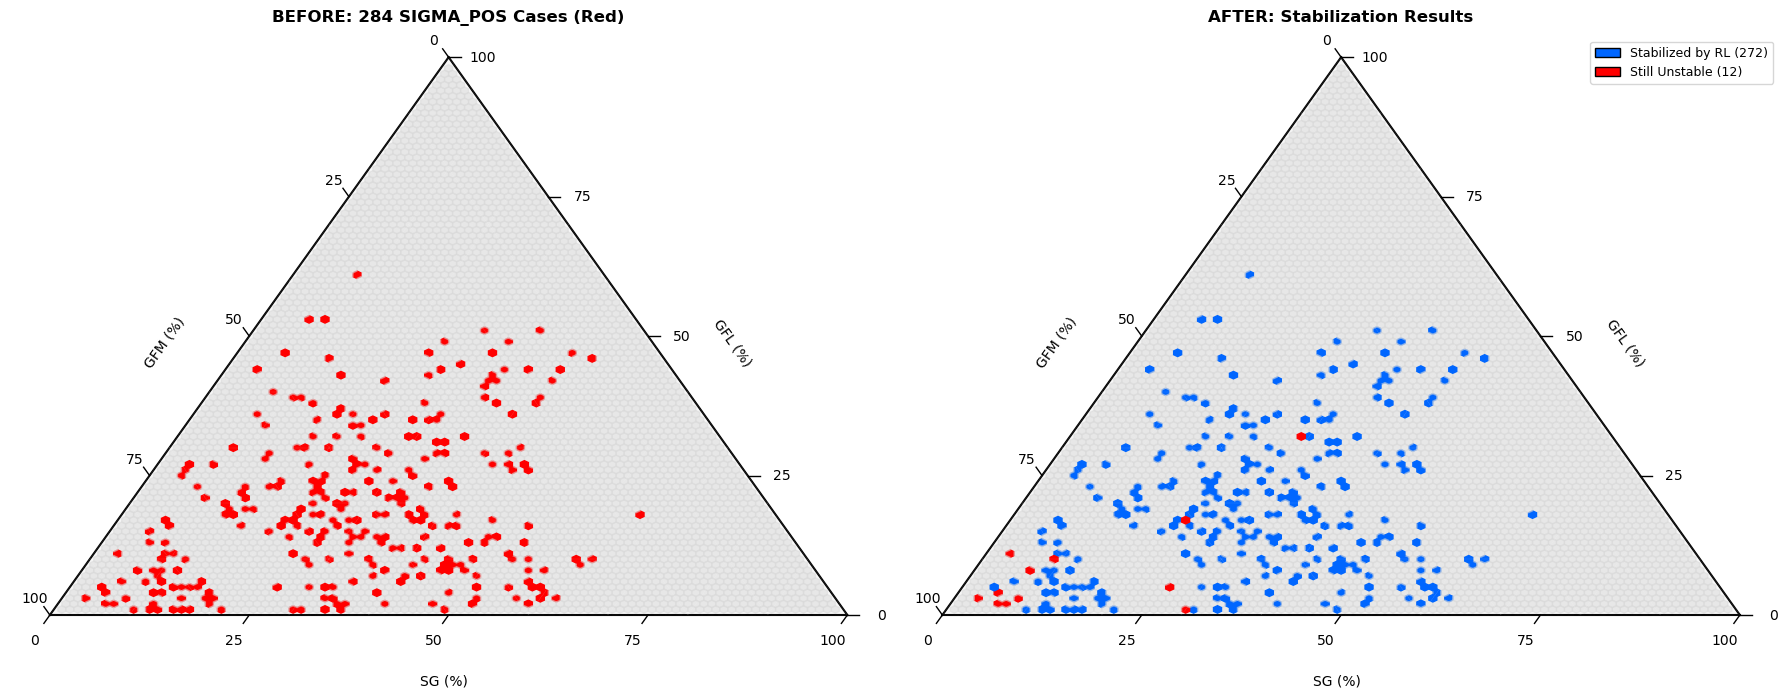


6. Scatter plot (dots)...


c:\Users\saigalm\AppData\Local\anaconda3\envs\PF\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


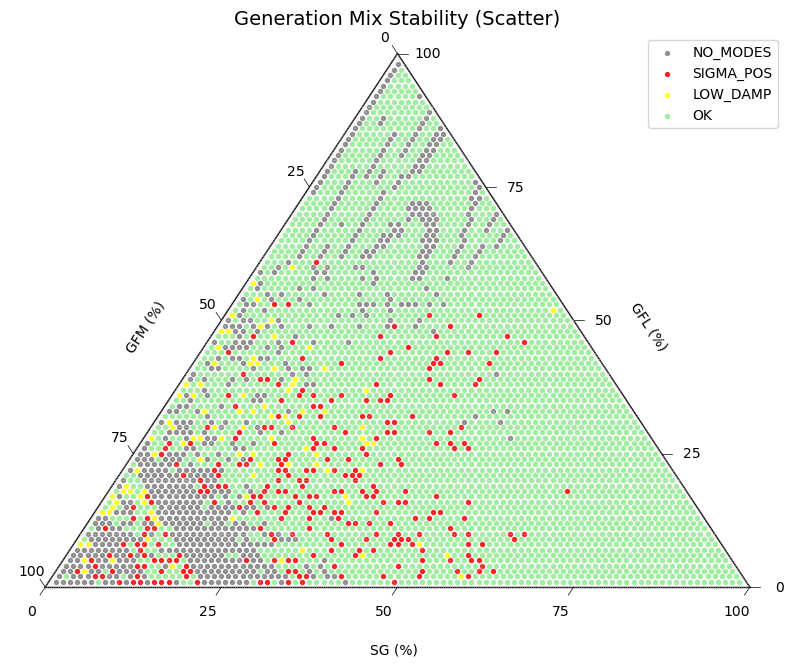


Done!


In [ ]:
import ternary
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def create_sigma_pos_before_after(df, scale=100, style="hexagonal", save_path=None):
    """
    Focus on SIGMA_POS cases: which were stabilized?
    
    Uses 'trained' and 'final_sigma' to determine outcome:
    - NOW_STABLE: final_sigma < 0 with best_K = 0
    - STABILIZED: final_sigma < 0 with best_K > 0
    - STILL_UNSTABLE: final_sigma >= 0 or not trained
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Colors
    color_bg = (0.85, 0.85, 0.85, 0.5)
    color_sigma_pos = (1.0, 0.0, 0.0, 1.0)
    color_now_stable = (0.2, 0.8, 0.2, 1.0)
    color_stabilized = (0.0, 0.4, 1.0, 1.0)
    color_still_unstable = (1.0, 0.0, 0.0, 1.0)
    
    sigma_pos_df = df[df['reason'] == 'SIGMA_POS']
    
    # ---- BEFORE ----
    data_before = {}
    for _, row in df.iterrows():
        i = int(round(row['eSG'] * scale))
        j = int(round(row['eGFM'] * scale))
        k = int(round(row['eGFL'] * scale))
        if i + j + k == scale:
            if row['reason'] == 'SIGMA_POS':
                data_before[(i, j, k)] = color_sigma_pos
            else:
                data_before[(i, j, k)] = color_bg
    
    tax1 = ternary.TernaryAxesSubplot(ax=ax1, scale=scale)
    tax1.heatmap(data_before, scale=scale, style=style, use_rgba=True, colorbar=False)
    tax1.boundary(linewidth=1.5)
    tax1.gridlines(color="white", multiple=scale//10, linewidth=0.3, alpha=0.5)
    tax1.left_axis_label("GFM (%)", fontsize=10, offset=0.12)
    tax1.right_axis_label("GFL (%)", fontsize=10, offset=0.12)
    tax1.bottom_axis_label("SG (%)", fontsize=10, offset=0.02)
    tax1.ticks(axis='lbr', linewidth=1, multiple=scale//4, offset=0.015)
    tax1.clear_matplotlib_ticks()
    tax1.get_axes().axis('off')
    ax1.set_title(f'BEFORE: {len(sigma_pos_df)} SIGMA_POS Cases (Red)', 
                  fontsize=12, fontweight='bold', pad=10)
    
    # ---- AFTER ----
    data_after = {}
    counts = {'NOW_STABLE': 0, 'STABILIZED': 0, 'STILL_UNSTABLE': 0}
    
    for _, row in df.iterrows():
        i = int(round(row['eSG'] * scale))
        j = int(round(row['eGFM'] * scale))
        k = int(round(row['eGFL'] * scale))
        if i + j + k == scale:
            if row['reason'] == 'SIGMA_POS':
                # Determine outcome
                final_sig = row['final_sigma']
                best_k = row['best_K']
                
                if pd.notna(final_sig) and final_sig < 0:
                    if best_k == 0 or pd.isna(best_k):
                        data_after[(i, j, k)] = color_now_stable
                        counts['NOW_STABLE'] += 1
                    else:
                        data_after[(i, j, k)] = color_stabilized
                        counts['STABILIZED'] += 1
                else:
                    data_after[(i, j, k)] = color_still_unstable
                    counts['STILL_UNSTABLE'] += 1
            else:
                data_after[(i, j, k)] = color_bg
    
    tax2 = ternary.TernaryAxesSubplot(ax=ax2, scale=scale)
    tax2.heatmap(data_after, scale=scale, style=style, use_rgba=True, colorbar=False)
    tax2.boundary(linewidth=1.5)
    tax2.gridlines(color="white", multiple=scale//10, linewidth=0.3, alpha=0.5)
    tax2.left_axis_label("GFM (%)", fontsize=10, offset=0.12)
    tax2.right_axis_label("GFL (%)", fontsize=10, offset=0.12)
    tax2.bottom_axis_label("SG (%)", fontsize=10, offset=0.02)
    tax2.ticks(axis='lbr', linewidth=1, multiple=scale//4, offset=0.015)
    tax2.clear_matplotlib_ticks()
    tax2.get_axes().axis('off')
    ax2.set_title('AFTER: Stabilization Results', fontsize=12, fontweight='bold', pad=10)
    
    # Legend with counts
    legend_elements = [
        mpatches.Patch(facecolor='#0066FF', edgecolor='black', 
                       label=f"Stabilized by RL ({counts['STABILIZED']})"),
        mpatches.Patch(facecolor='#FF0000', edgecolor='black', 
                       label=f"Still Unstable ({counts['STILL_UNSTABLE']})"),
    ]
    ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    print(f"\nOutcome counts: {counts}")
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig


def create_scatter_plot(df, scale=100, save_path=None):
    """Original dot-style scatter plot."""
    color_map = {
        'OK': 'lightgreen',
        'LOW_DAMP': 'yellow',
        'SIGMA_POS': 'red',
        'NO_MODES': 'gray'
    }
    
    figure, tax = ternary.figure(scale=scale)
    figure.set_size_inches(10, 8)
    
    tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=scale//10, color="lightgray")
    
    for reason in ['NO_MODES', 'SIGMA_POS', 'LOW_DAMP', 'OK']:
        subset = df[df['reason'] == reason]
        if len(subset) > 0:
            points = [(row['eSG']*scale, row['eGFM']*scale, row['eGFL']*scale) 
                      for _, row in subset.iterrows()]
            tax.scatter(points, marker='o', color=color_map[reason], s=8, alpha=0.8, label=reason)
    
    tax.left_axis_label("GFM (%)", fontsize=10, offset=0.12)
    tax.right_axis_label("GFL (%)", fontsize=10, offset=0.12)
    tax.bottom_axis_label("SG (%)", fontsize=10, offset=0.02)
    tax.ticks(axis='lbr', linewidth=0.5, multiple=scale//4, offset=0.015)
    tax.legend(loc='upper right')
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.set_title("Generation Mix Stability (Scatter)", fontsize=14)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return figure, tax


# ============================================================
# RUN ALL
# ============================================================

if __name__ == "__main__":
    df = pd.read_csv(r'summary_all_mixes.csv') ## change the path
    scale = 100
    
    print("=" * 60)
    print("Creating ternary plots...")
    print("=" * 60)
    
    # SIGMA_POS before/after (categorical)
    print("\n5. SIGMA_POS stabilization results...")
    create_sigma_pos_before_after(df, scale=scale, style="hexagonal")
    
    # Scatter plot (dots)
    print("\n6. Scatter plot (dots)...")
    create_scatter_plot(df, scale=scale)
    
    print("\n" + "=" * 60)
    print("Done!")

POST-FAULT VOLTAGE ANALYSIS
Loaded points: 6012
Voltage buses: ['Bus 1', 'Bus 2', 'Bus 3', 'Bus 4', 'Bus 5', 'Bus 6', 'Bus 7', 'Bus 8', 'Bus 9', 'LV PV']
Voltage buses: ['Bus 1', 'Bus 2', 'Bus 3', 'Bus 4', 'Bus 5', 'Bus 6', 'Bus 7', 'Bus 8', 'Bus 9', 'LV PV']


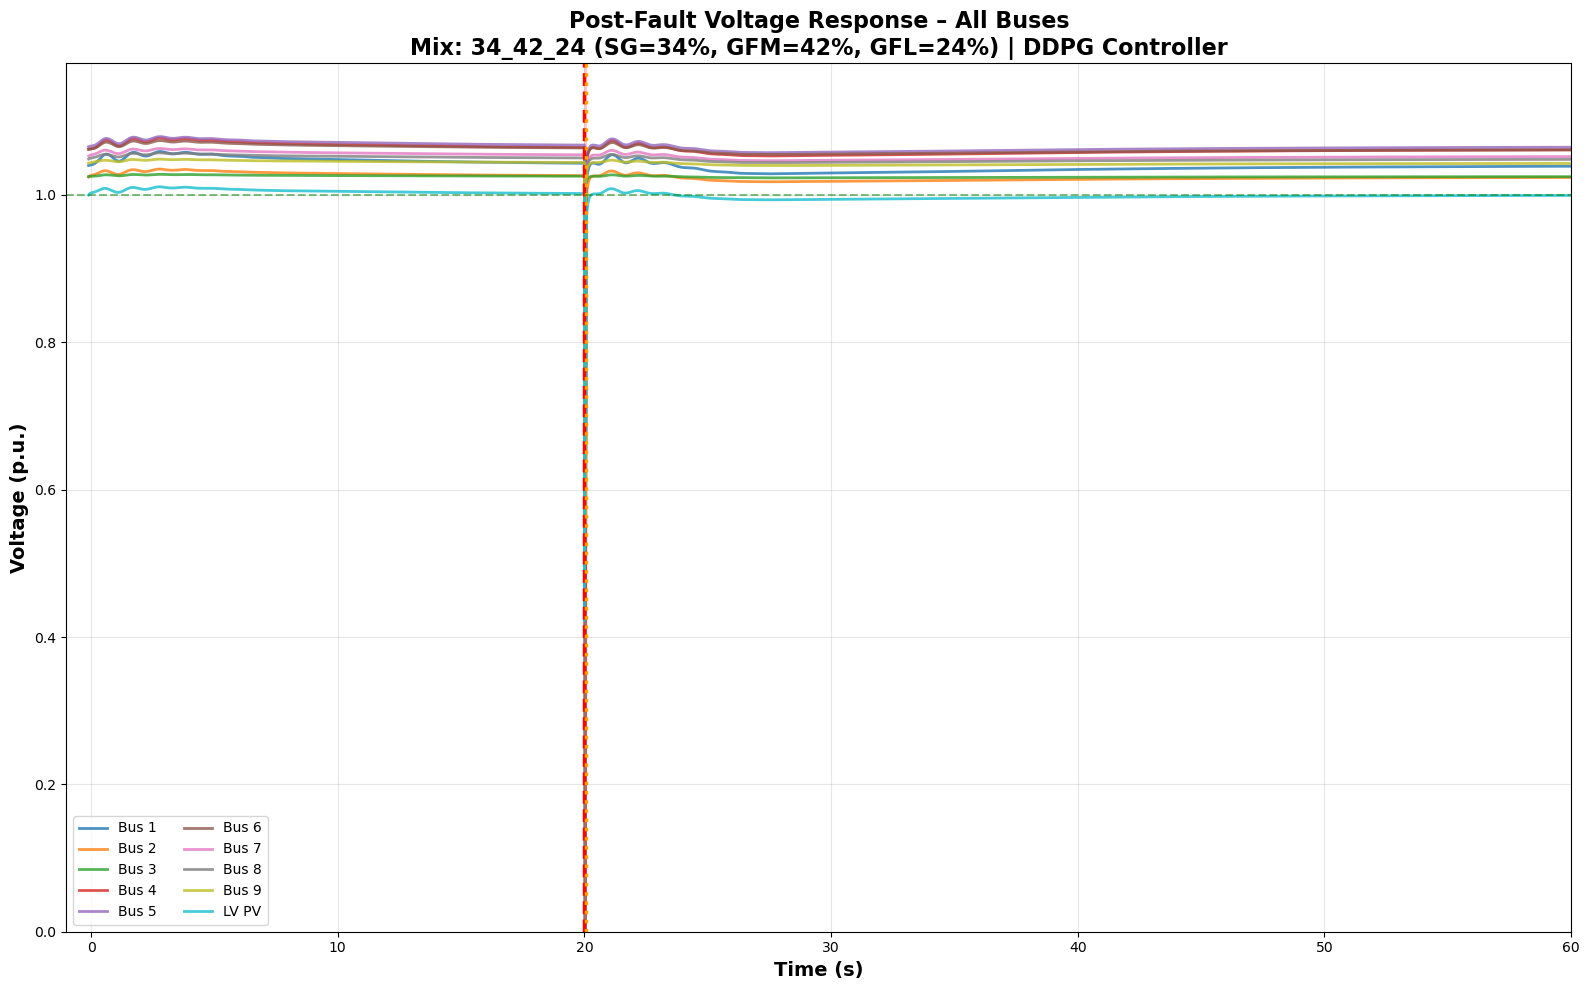

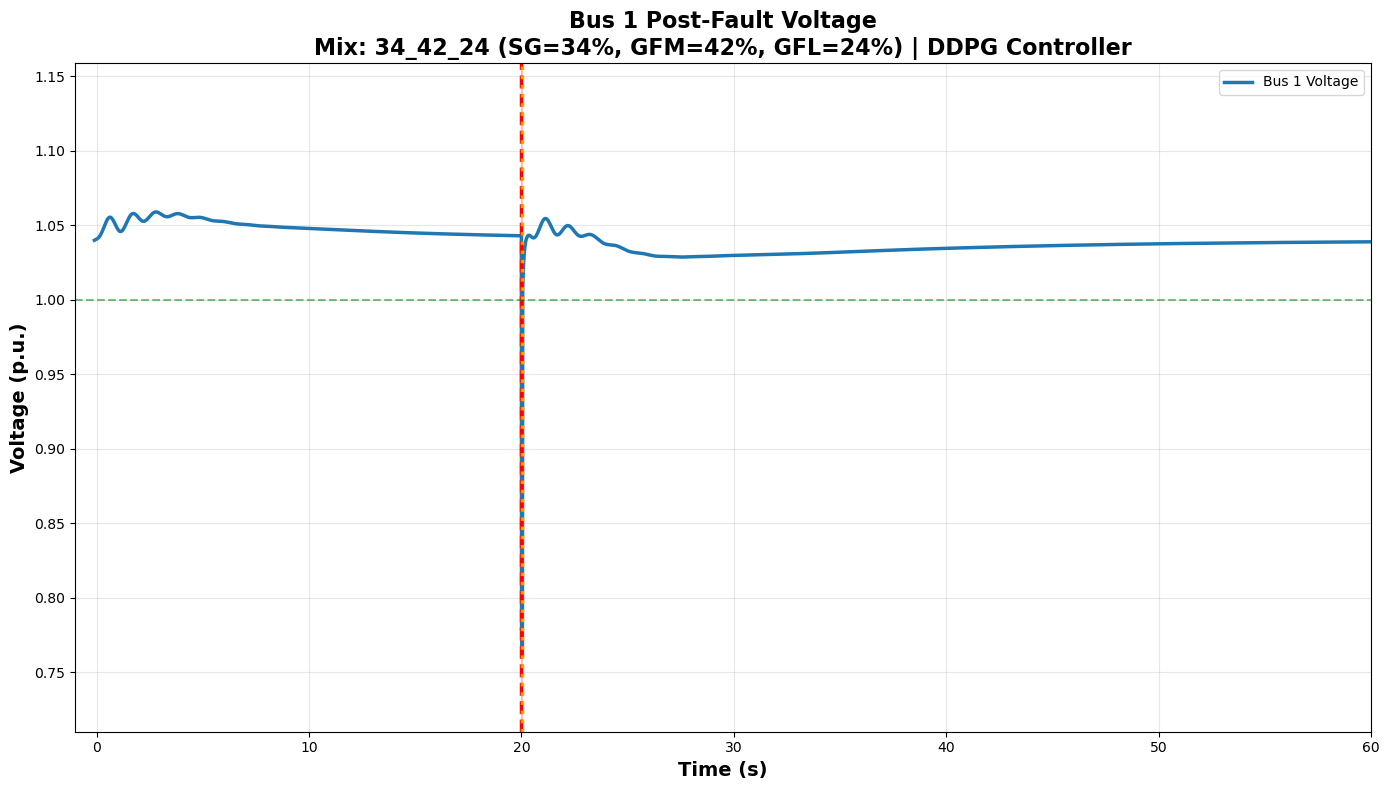

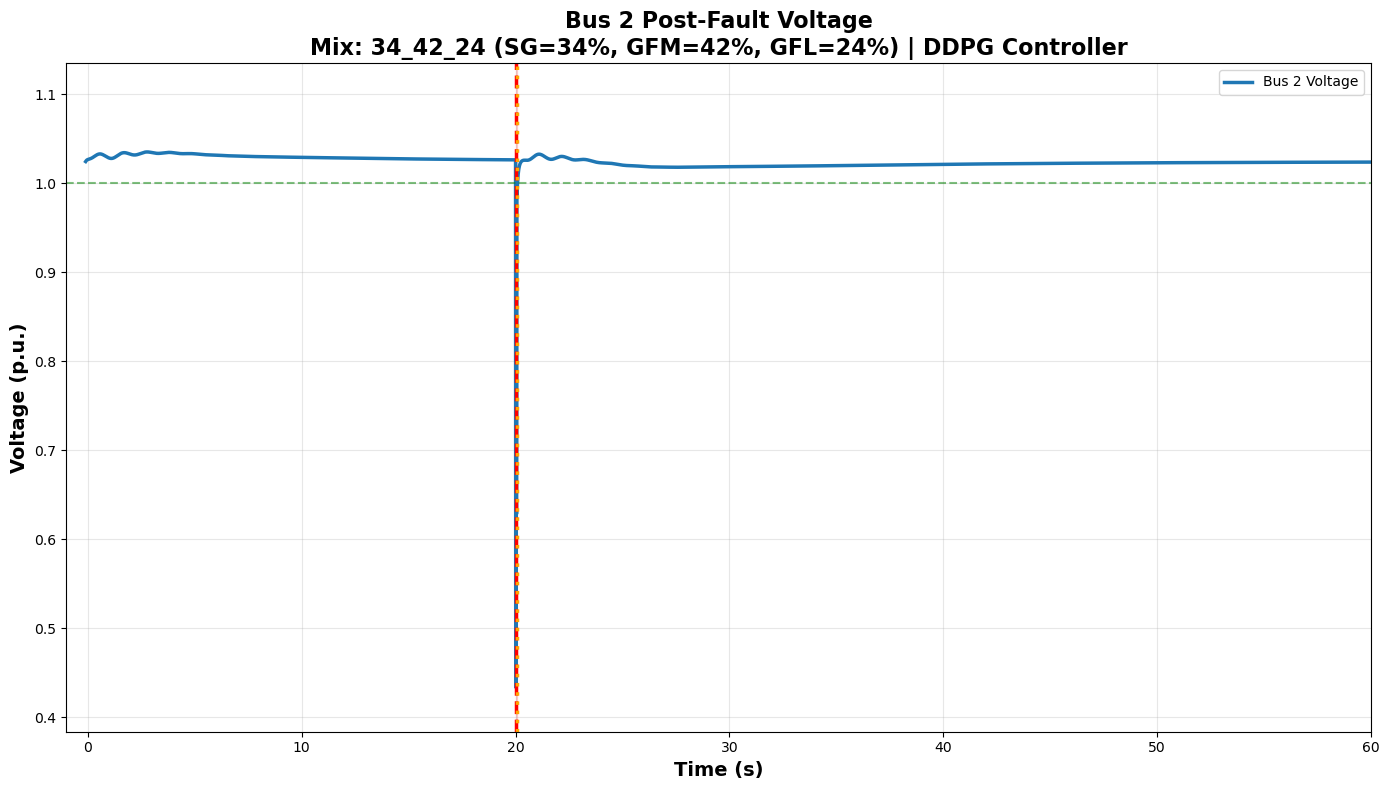

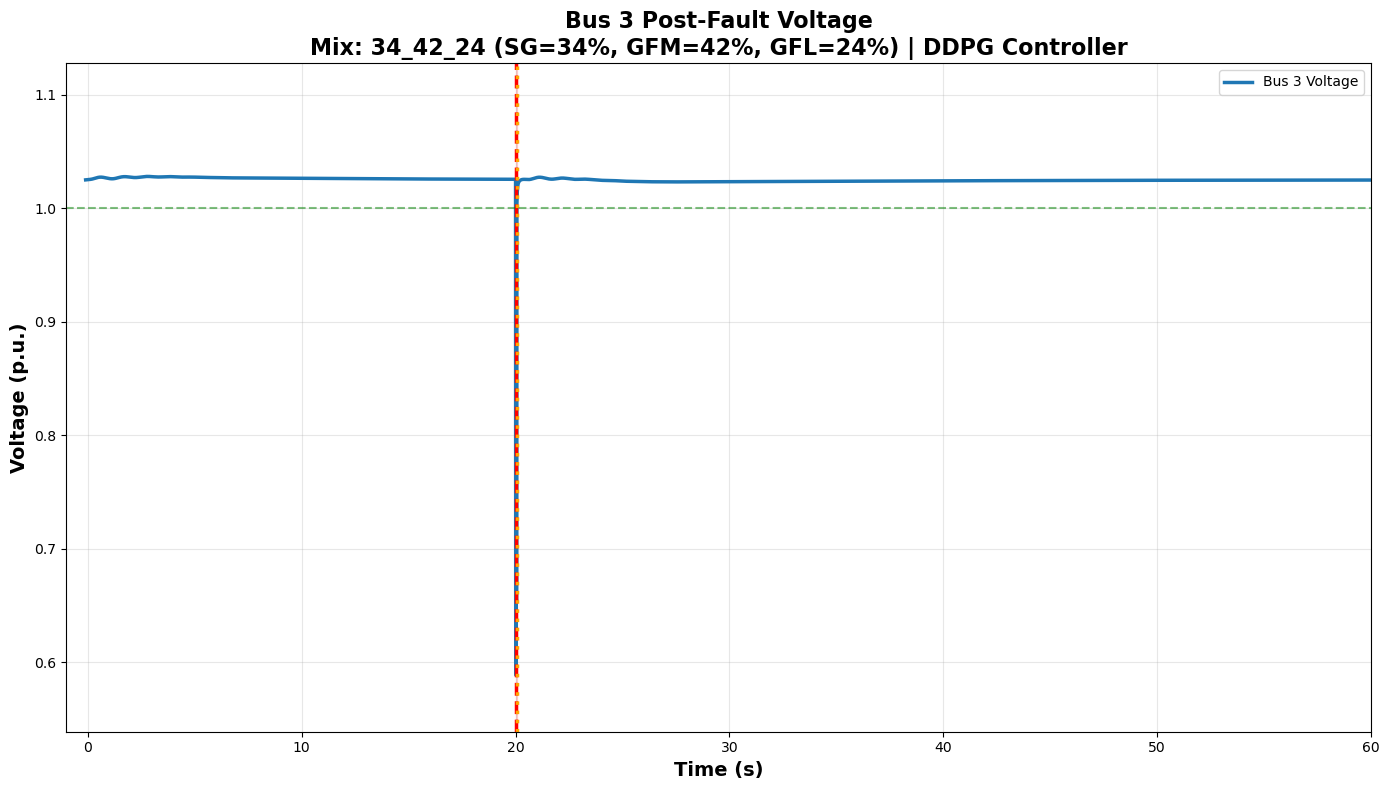

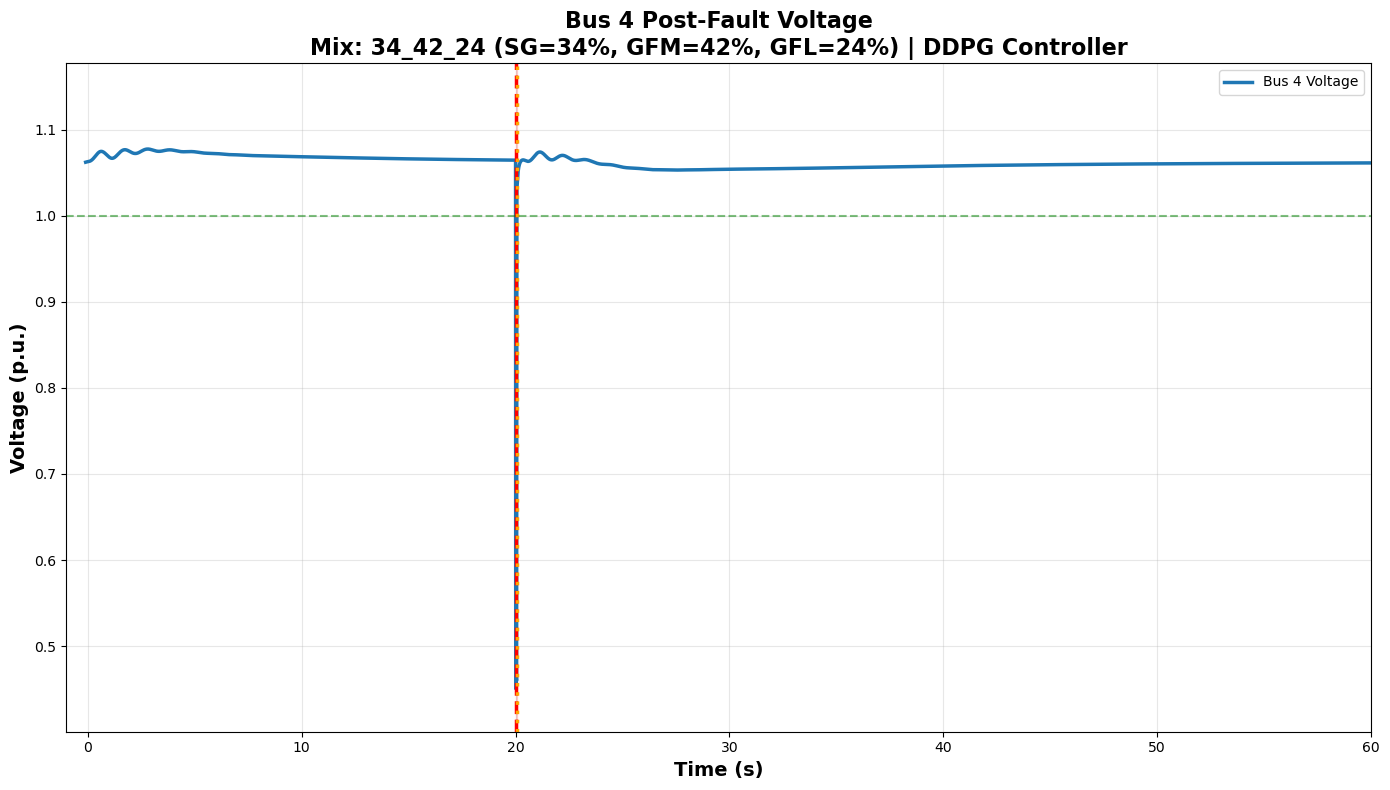

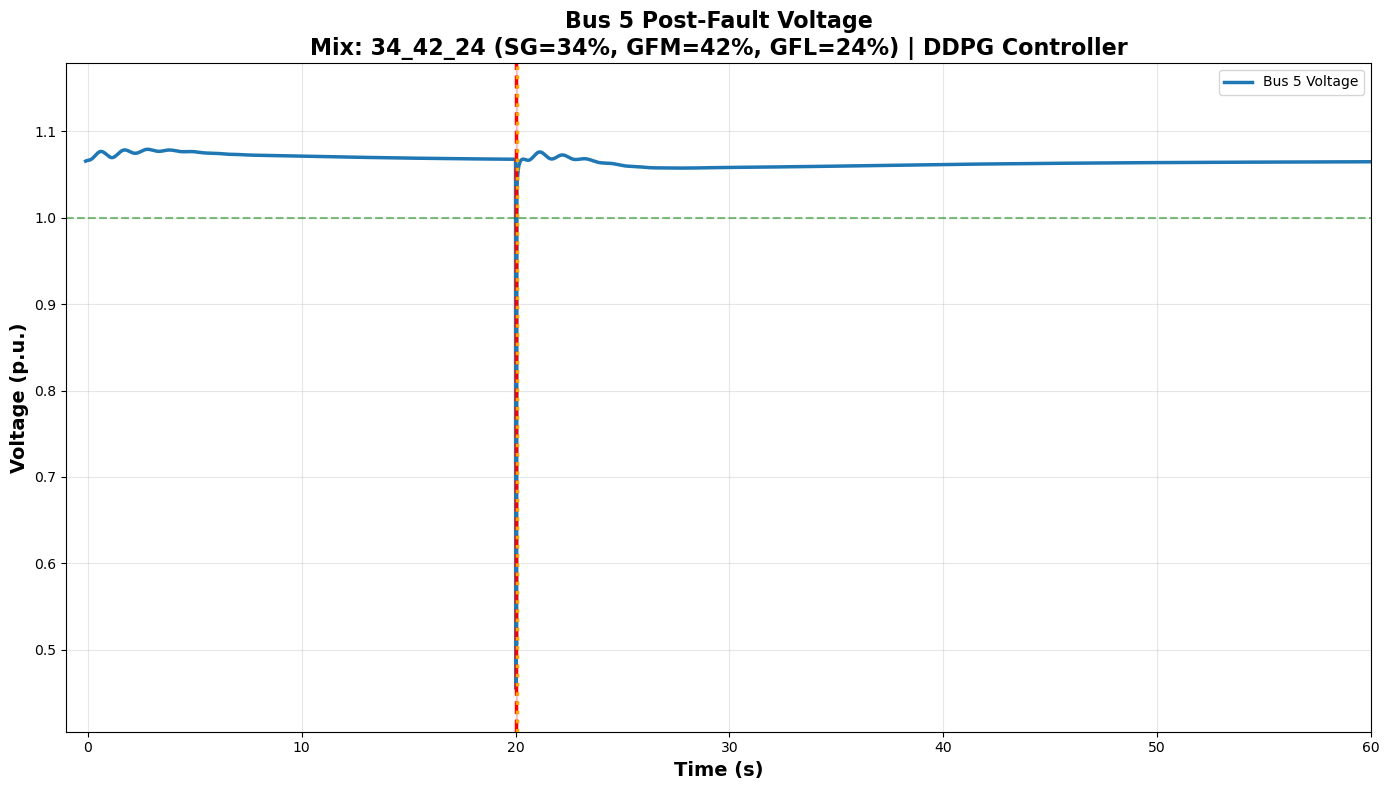

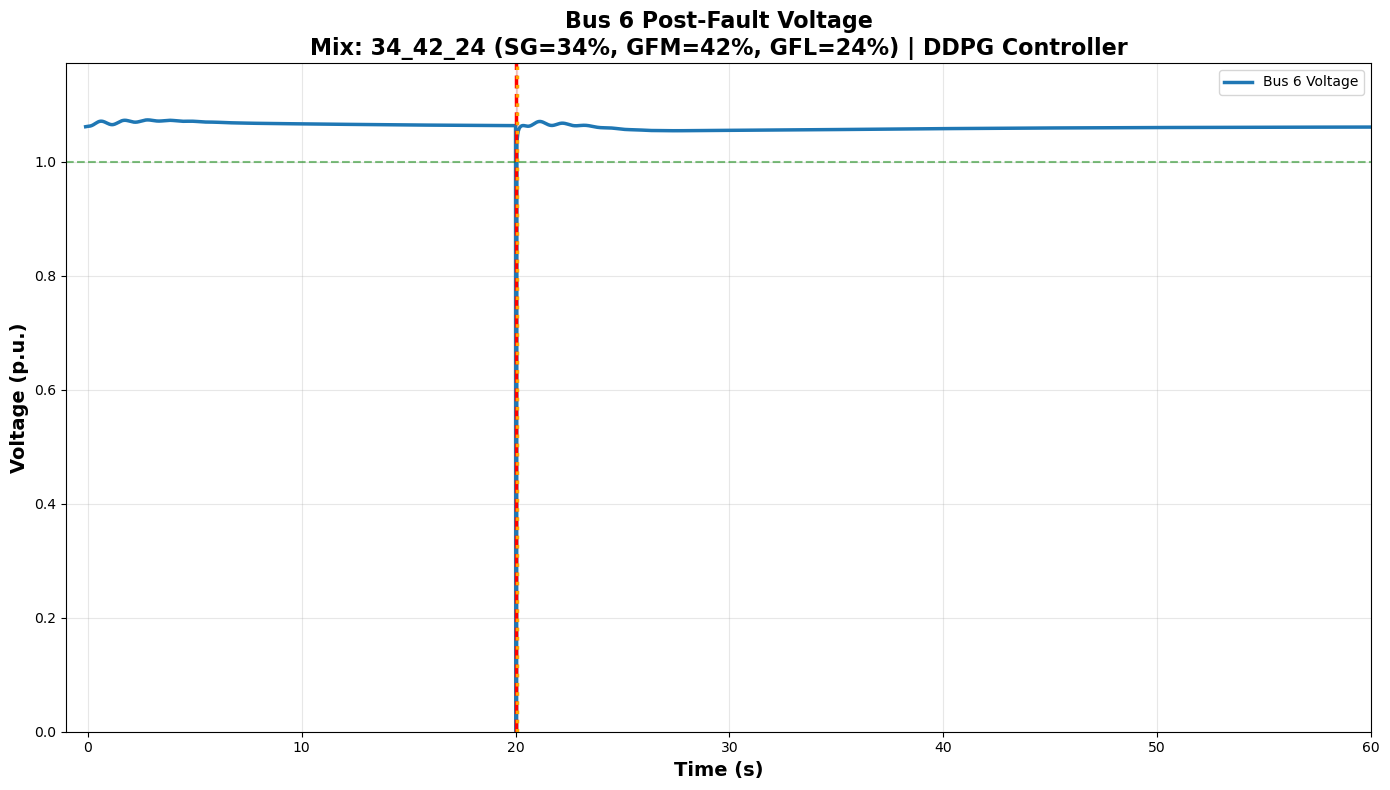

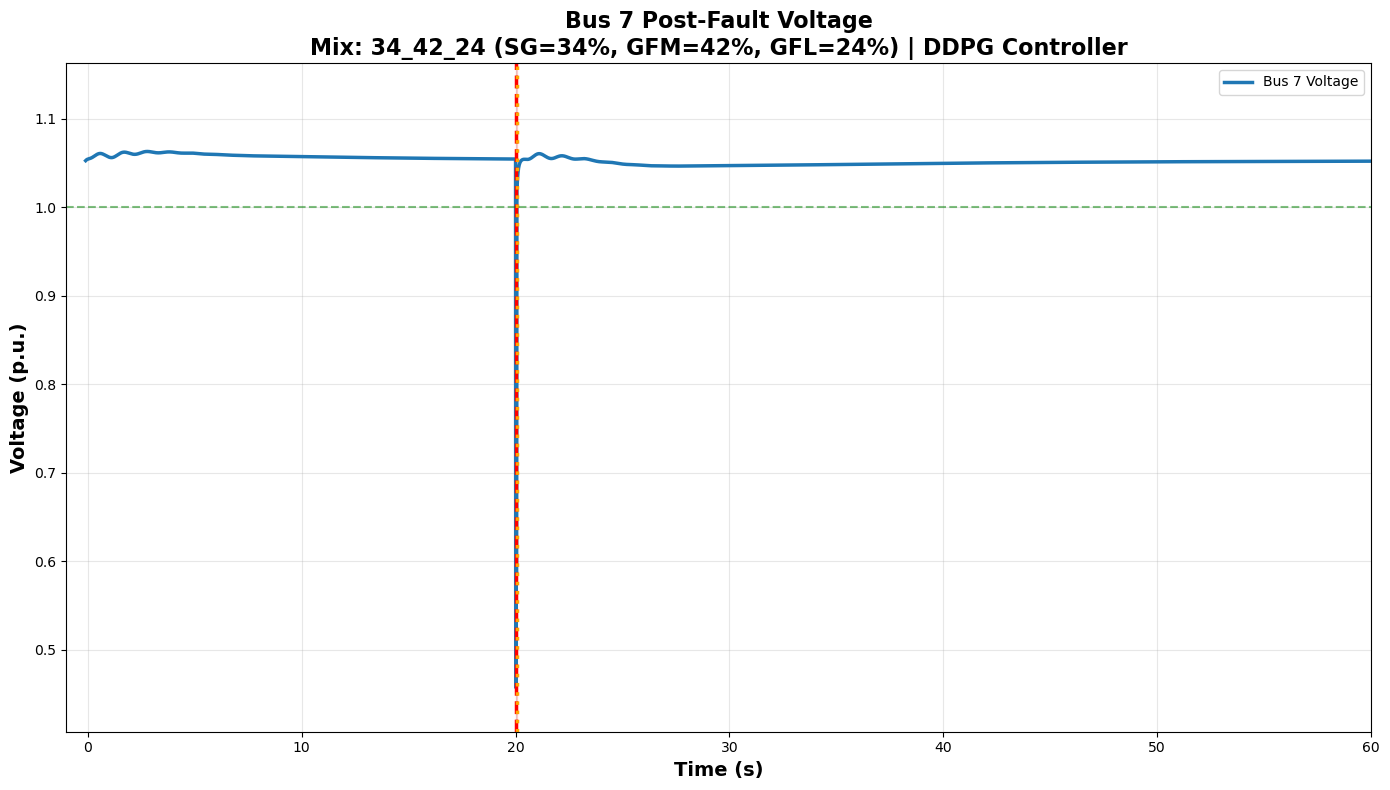

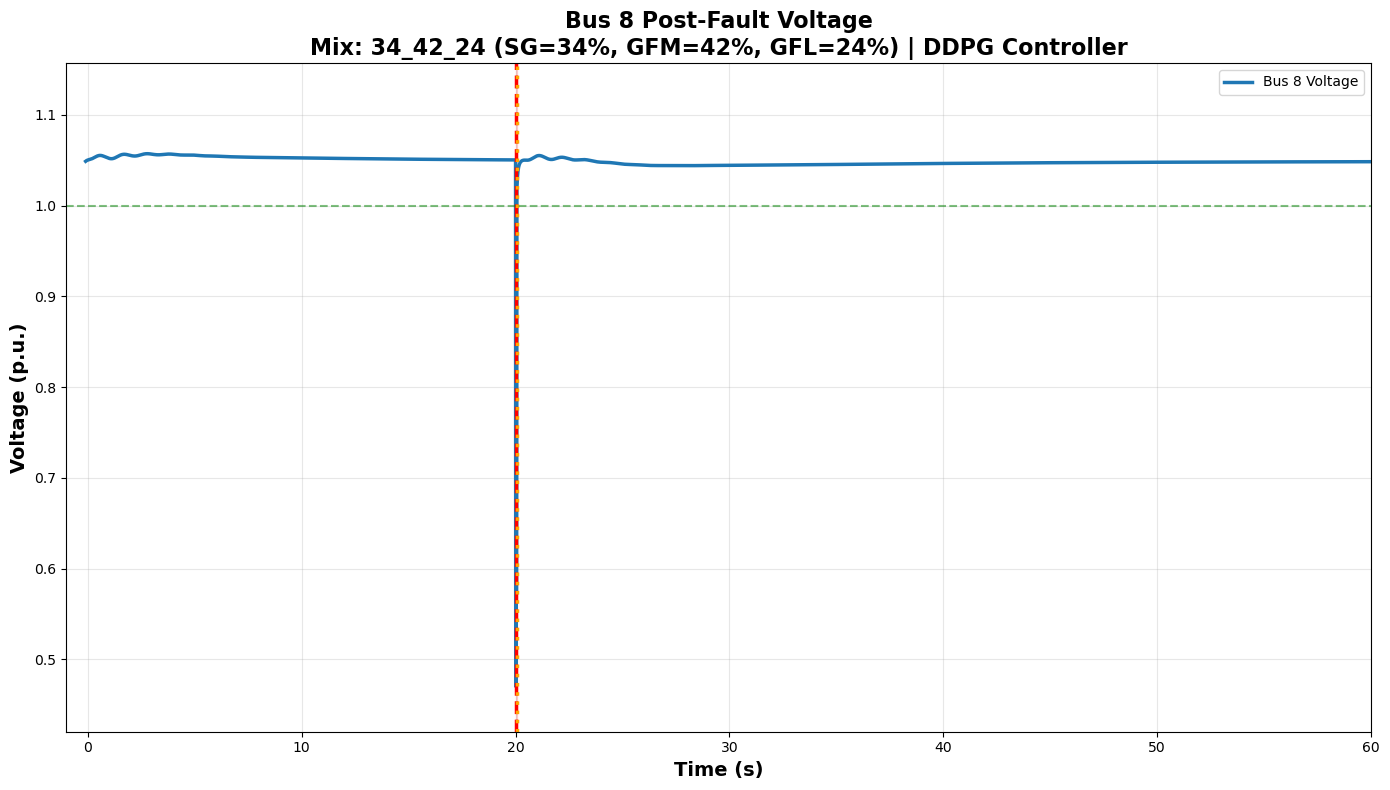

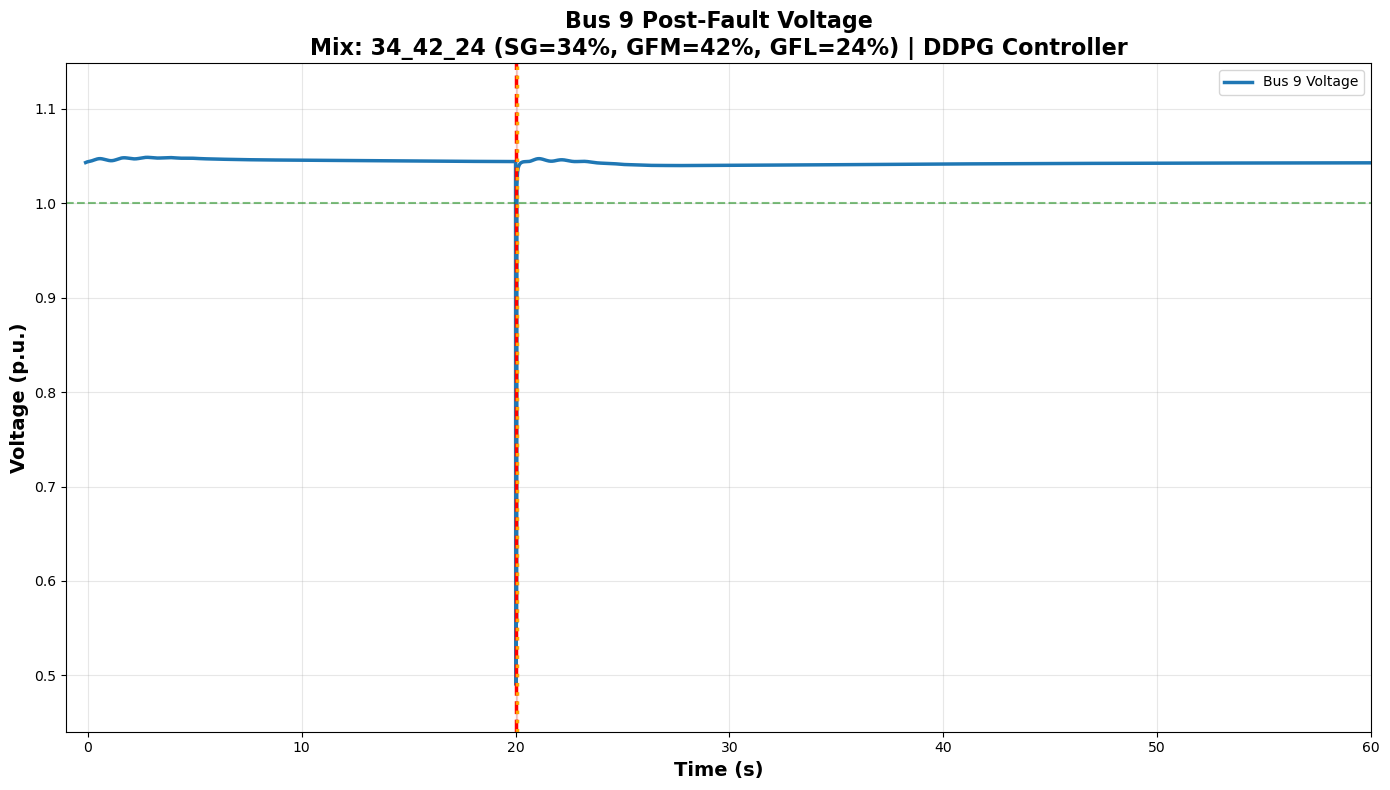

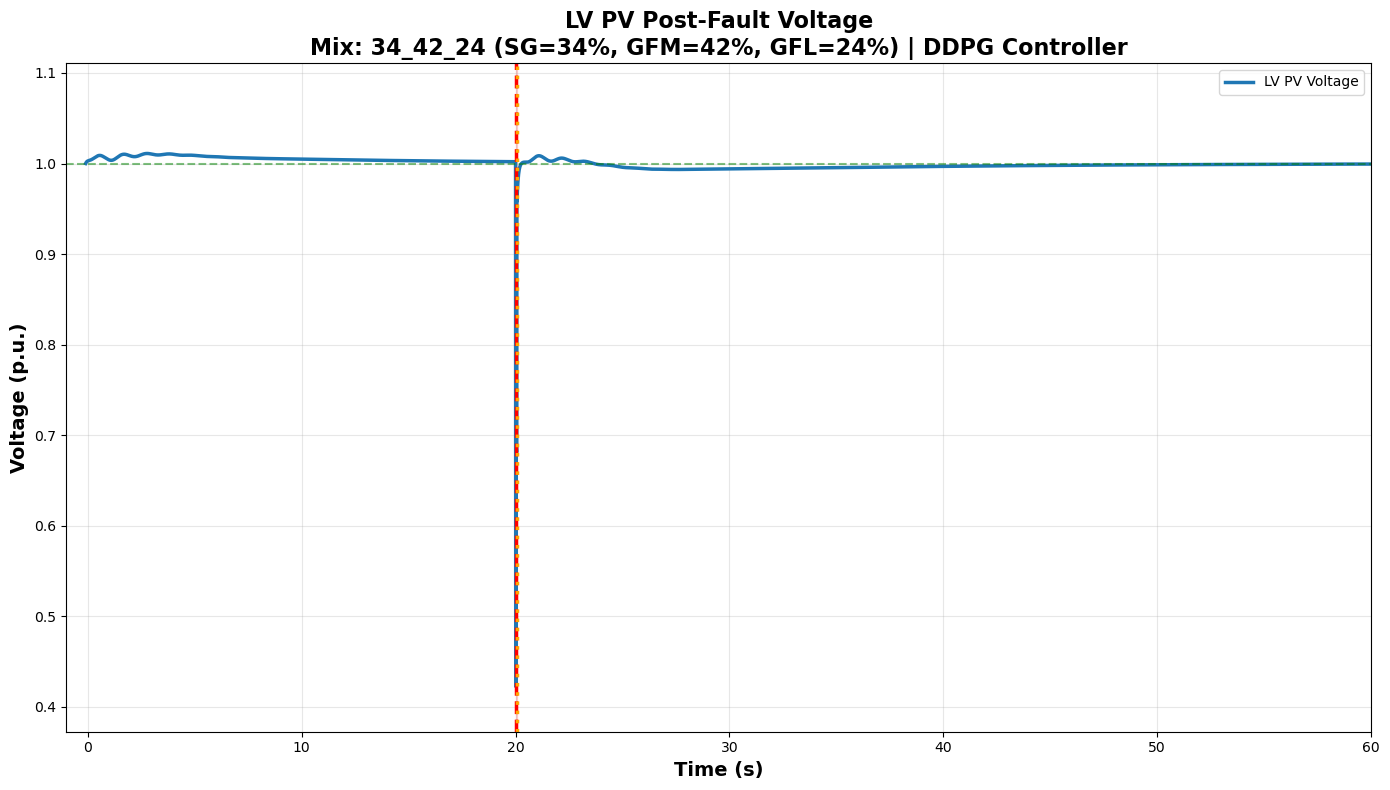


VOLTAGE METRICS SUMMARY
  bus     mean      std      min      max  overshoot_pct  undershoot_pct
Bus 1 1.035743 0.004848 0.940667 1.054634       5.463391        5.933283
Bus 2 1.021822 0.005571 0.717523 1.032631       3.263083       28.247735
Bus 3 1.024228 0.005656 0.670844 1.027317       2.731748       32.915639
Bus 4 1.058580 0.004643 0.883834 1.073909       7.390860       11.616625
Bus 5 1.062408 0.004802 0.845842 1.076126       7.612638       15.415768
Bus 6 1.059200 0.004678 0.828695 1.071142       7.114223       17.130451
Bus 7 1.050259 0.005314 0.759095 1.060582       6.058242       24.090497
Bus 8 1.046804 0.005320 0.739088 1.055091       5.509064       26.091176
Bus 9 1.041821 0.005424 0.711385 1.047252       4.725179       28.861478
LV PV 0.997422 0.005773 0.682851 1.008592       0.859243       31.714888

Analysis complete


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


def load_and_process_data(csv_path, downsample_factor=100):

    df_raw = pd.read_csv(csv_path, header=None, low_memory=False)

    element_names = df_raw.iloc[0].values
    variable_names = df_raw.iloc[1].values
    column_names = ['time'] + [
        f"{e}_{v}" for e, v in zip(element_names[1:], variable_names[1:])
    ]

    df = df_raw.iloc[2:].copy()
    df.columns = column_names
    df.reset_index(drop=True, inplace=True)

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.iloc[::downsample_factor].copy()

    print(f"Loaded points: {len(df)}")
    return df


def get_voltage_columns(df):
    # Extract voltage signals
    voltage_cols = {
        col.replace('_m:u1 in p.u.', ''): col
        for col in df.columns
        if 'm:u1 in p.u.' in col
    }

    print(f"Voltage buses: {list(voltage_cols.keys())}")
    return voltage_cols


def plot_all_buses_voltage(df, mix_id, controller_info,
                           fault_time=20, fault_duration=0.05, start_time=0):
    voltage_cols = get_voltage_columns(df)
    time = df['time'].values

    plot_start = start_time - 1
    mask = time >= plot_start
    time_f = time[mask]

    fig, ax = plt.subplots(figsize=(16, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(voltage_cols)))

    for i, (bus, col) in enumerate(sorted(voltage_cols.items())):
        ax.plot(
            time_f,
            df[col].values[mask],
            label=bus,
            linewidth=2,
            alpha=0.8,
            color=colors[i]
        )

    ax.axvline(fault_time, color='r', linestyle='--', linewidth=2.5)
    ax.axvline(fault_time + fault_duration, color='orange', linestyle=':', linewidth=2.5)
    ax.axvspan(fault_time, fault_time + fault_duration, color='red', alpha=0.15)
    ax.axhline(1.0, color='green', linestyle='--', alpha=0.5)

    ax.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Voltage (p.u.)', fontsize=14, fontweight='bold')
    ax.set_title(
        f'Post-Fault Voltage Response – All Buses\nMix: {mix_id} | {controller_info}',
        fontsize=16,
        fontweight='bold'
    )

    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2)
    ax.set_xlim([plot_start, time_f[-1]])

    all_v = np.concatenate([df[c].values[mask] for c in voltage_cols.values()])
    ax.set_ylim([max(0, all_v.min() - 0.05), all_v.max() + 0.1])

    plt.tight_layout()
    plt.show()

    return fig


def plot_individual_bus_voltage(df, bus_name, col_name, mix_id, controller_info,
                                fault_time=20, fault_duration=0.05, start_time=0):
    time = df['time'].values
    voltage = df[col_name].values

    plot_start = start_time - 1
    mask = time >= plot_start
    t = time[mask]
    v = voltage[mask]

    post_mask = t > (fault_time + fault_duration)
    if np.any(post_mask):
        v_post = v[post_mask]
        v_mean, v_std = v_post.mean(), v_post.std()
        v_min, v_max = v_post.min(), v_post.max()
        overshoot = (v_max - 1.0) * 100
        undershoot = (1.0 - v_min) * 100
    else:
        v_mean = v_std = v_min = v_max = overshoot = undershoot = 0

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(t, v, linewidth=2.5, label=f'{bus_name} Voltage')

    ax.axvline(fault_time, color='r', linestyle='--', linewidth=2.5)
    ax.axvline(fault_time + fault_duration, color='orange', linestyle=':', linewidth=2.5)
    ax.axvspan(fault_time, fault_time + fault_duration, color='red', alpha=0.15)
    ax.axhline(1.0, color='green', linestyle='--', alpha=0.5)

    ax.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Voltage (p.u.)', fontsize=14, fontweight='bold')
    ax.set_title(
        f'{bus_name} Post-Fault Voltage\nMix: {mix_id} | {controller_info}',
        fontsize=16,
        fontweight='bold'
    )

    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlim([plot_start, t[-1]])
    ax.set_ylim([max(0, v.min() - 0.05), v.max() + 0.1])

    plt.tight_layout()
    plt.show()

    return {
        'bus': bus_name,
        'mean': v_mean,
        'std': v_std,
        'min': v_min,
        'max': v_max,
        'overshoot_pct': overshoot,
        'undershoot_pct': undershoot
    }


def run_post_fault_analysis(csv_path, mix_id, controller_info="With Controller",
                            fault_time=20, fault_duration=0.05,
                            downsample_factor=100):
    print("=" * 60)
    print("POST-FAULT VOLTAGE ANALYSIS")
    print("=" * 60)

    df = load_and_process_data(csv_path, downsample_factor)
    voltage_cols = get_voltage_columns(df)

    fig_all = plot_all_buses_voltage(
        df, mix_id, controller_info, fault_time, fault_duration
    )

    metrics = []
    for bus, col in sorted(voltage_cols.items()):
        metrics.append(
            plot_individual_bus_voltage(
                df, bus, col, mix_id, controller_info,
                fault_time, fault_duration
            )
        )

    metrics_df = pd.DataFrame(metrics)

    print("\nVOLTAGE METRICS SUMMARY")
    print(metrics_df.to_string(index=False))
    print("\nAnalysis complete")

    return df, metrics_df, fig_all


if __name__ == "__main__":
    csv_path = (r'timeseries_step02_K7.00.csv')

    mix_id = '34_42_24 (SG=34%, GFM=42%, GFL=24%)'
    controller_info = 'DDPG Controller'

    df, metrics, fig = run_post_fault_analysis(
        csv_path=csv_path,
        mix_id=mix_id,
        controller_info=controller_info,
        fault_time=20,
        fault_duration=0.05,
        downsample_factor=10
    )
